# Importación librerias

In [1]:
import pickle
import  os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve, average_precision_score



# Carga de Datos

Cargamos los distintos Csv que hemos preparado para entrenar los modelos, estos se encuentran en la carpeta `data/processed`

In [2]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(BASE_DIR, "data", "processed")
file_name = "Propensity_clean_v1.csv"  #cambiar si queremosm probar con otras versiones
file_path = os.path.join(DATA_DIR, file_name)

df = pd.read_csv(file_path)

In [3]:
print(" Datos cargados correctamente.")
df.head() 

 Datos cargados correctamente.


,PRODUCTO,TIPO_CARROCERIA,COMBUSTIBLE,Potencia,TRANS,FORMA_PAGO,ESTADO_CIVIL,GENERO,OcupaciOn,PROVINCIA,...,Zona_Renta,REV_Garantia,Averia_grave,QUEJA_CAC,COSTE_VENTA,km_anno,Mas_1_coche,Revisiones,Edad_Cliente,Tiempo
0,0,0,0,0,1,0,0,1,1,4,...,1,0,3,1,2892,0,0,2,18,0
1,0,0,0,0,1,0,0,0,1,46,...,1,1,0,0,1376,7187,0,2,53,0
2,0,0,0,0,1,3,0,1,1,29,...,2,0,0,0,1376,0,1,4,21,3
3,0,0,0,0,1,2,0,0,1,31,...,2,1,3,1,2015,7256,1,4,48,5
4,0,0,0,0,1,2,0,0,2,40,...,3,0,0,0,1818,0,1,3,21,3


# Entrenamiento modelo

## Selección de Hiperparámetros Óptimos

Se realizó una búsqueda de hiperparámetros evaluando múltiples combinaciones. Se seleccionó el modelo con **mayor F1-score y accuracy**, obteniendo los valores siguientes valores óptimos que usaremos a continuación en el modelo XGboost.  

Esta selección de parámetros se realiza en la sección **modelo**.


## Entrenamiento del modelo

In [4]:
def entrenar_modelo(X_train, y_train):
    model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    n_estimators=200,
    learning_rate=0.1,
    max_depth=8,
    min_child_weight=3,
    gamma=0.3,
    subsample=0.8,
    colsample_bytree=0.9,
    reg_lambda=1.0,  # Regularización L2 (por defecto 1.0)
    reg_alpha=0.0,   # Regularización L1 (por defecto 0.0)
    random_state=42,
    n_jobs=-1
    )
    model.fit(X_train, y_train)
    return model

## Metricas Modelo

In [5]:
def evaluar_modelo(model, X_train, y_train, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc", n_jobs=-1)
    mean_cv_score = np.mean(cv_scores)

    train_score = model.score(X_train, y_train)
    
    if train_score > 1.5 * mean_cv_score:
        overfitting = "SEVERE OVERFITTING"
    elif train_score > 1.2 * mean_cv_score:
        overfitting = "DANGER"
    elif train_score > 1.1 * mean_cv_score:
        overfitting = "MILD OVERFITTING"
    else:
        overfitting = "OK"

    print(f"\nResultados del Modelo:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC Score: {roc_auc:.4f}")
    print(f"CV Score: {mean_cv_score:.4f}")
    print(f"Train Score: {train_score:.4f}")
    print(f"Overfitting: {overfitting}\n")

    return y_pred, y_pred_proba




## Graficas y Matriz Confusión

In [6]:
def mostrar_classification_report(y_test, y_pred):
    print("\n Classification Report:")
    print(classification_report(y_test, y_pred))

In [7]:
def plot_roc(y_test, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC={roc_auc_score(y_test, y_pred_proba):.2f})", color="blue")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Curva ROC - XGBoost")
    plt.legend()
    plt.show()
    

def plot_precision_recall(y_test, y_pred_proba):
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)

    plt.figure(figsize=(8,6))
    plt.plot(recall, precision, label=f"Precision-Recall Curve (AP={avg_precision:.2f})", color="blue")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Curva Precision-Recall - XGBoost")
    plt.legend()
    plt.show()

    return avg_precision



def plot_confusion_matrix(y_test, y_pred):
    plt.figure(figsize=(6,5))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=["No Compra", "Compra"], yticklabels=["No Compra", "Compra"])
    plt.xlabel("Predicción")
    plt.ylabel("Realidad")
    plt.title("Matriz de Confusión - XGBoost")
    plt.show()

# Evaluación del Modelo


En la sección **resultados**, se evaluará el modelo seleccionado con los distintos archivos CSV ubicados en `data/processed`.  

Estos archivos son el resultado de aplicar diferentes tratamientos a los valores nulos y variables categóricas.


## Propensity_clean_v1.csv

In [8]:
df = df.drop(columns=["Tiempo"], errors="ignore")
y = df["Mas_1_coche"]
X = df.drop(columns=["Mas_1_coche"])

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [10]:
model_1 = entrenar_modelo(X_train, y_train)

In [11]:
y_pred, y_pred_proba = evaluar_modelo(model_1, X_train, y_train, X_test, y_test)



Resultados del Modelo:
Accuracy: 0.8411
Precision: 0.7743
Recall: 0.7379
F1 Score: 0.7557
ROC-AUC Score: 0.9290
CV Score: 0.9281
Train Score: 0.9369
Overfitting: OK



In [12]:
mostrar_classification_report(y_test, y_pred)


 Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      5886
           1       0.77      0.74      0.76      2938

    accuracy                           0.84      8824
   macro avg       0.82      0.82      0.82      8824
weighted avg       0.84      0.84      0.84      8824



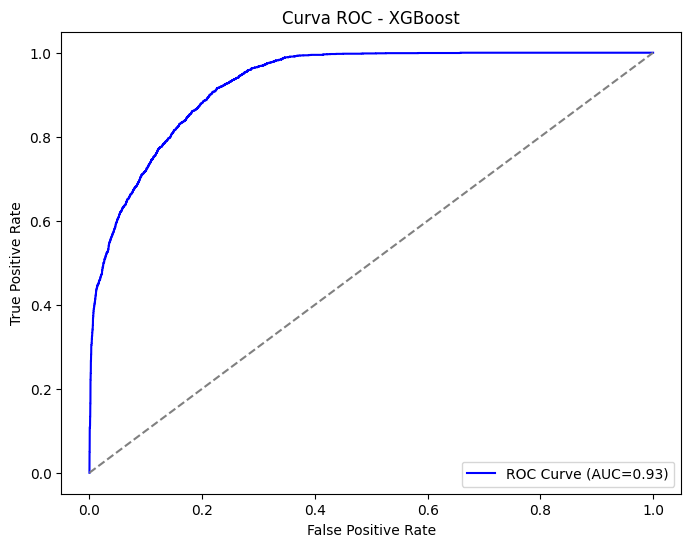

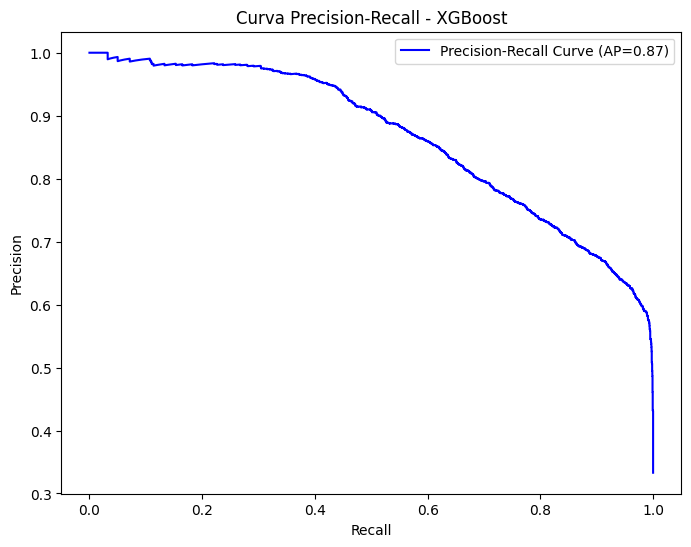

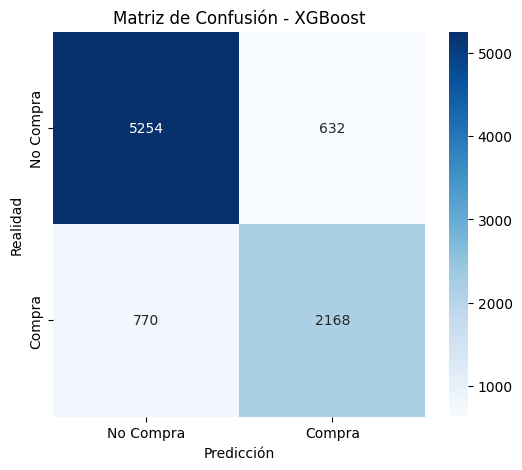

In [13]:
plot_roc(y_test, y_pred_proba)
plot_precision_recall(y_test,y_pred_proba)

plot_confusion_matrix(y_test, y_pred)



# Propen